In [13]:
%matplotlib inline
import sys,os
import csv
import numpy as np
from scipy import stats
import matplotlib
from matplotlib import pylab as py
import pandas as pd
import matplotlib.pyplot as plt

In [14]:
def calc_recurrence(df, min_mag = None, max_mag = None, interval = 0.1):
    """
    This function reads an earthquake catalogue file and calculates the
    Gutenberg-Richter recurrence parameters using both least squares and
    maximum likelihood (Aki 1965) approaches.

    Results are plotted for both straightline fits and bounded
    Gutenberg-Richter curves. Also plotted is the curve that would result
    assuming a b-value of 1.

    Funtion arguments:

        infile: file containing earthquake catalogue
                Expected input file format: csv
                One header line
                Year of earthquake in 3rd column, magnitude in 6th column.
        min_mag: minimum magnitude for which data will be used - i.e. catalogue
                completeness
        max_mag: maximum magnitude used in bounded G-R curve. If not specified,
                defined as the maximum magnitude in the catlogue + 0.1 magnitude
                units.
        interval: Width of magnitude bins for generating cumulative histogram
                of earthquake recurrence. Default avlue 0.1 magnitude units.  
    
    """
    magnitudes = df.prefmag.values
    years = df.year_float.values
    print 'Checkpoint 0'
    
    ###########################################################################
    # Read data
    ###########################################################################
    
    # If maximum magnitude is not specified default value to maximum in catalogue
    if max_mag is not None:
        pass
    else:
        max_mag = magnitudes.max() + 0.1
        
    if min_mag is not None:
        pass
    else:
        min_mag = magnitudes.min()

    num_eq = len(magnitudes)
    print 'Minimum magnitude:', min_mag
    print 'Total number of earthquakes:', num_eq
    num_years = years.max()-years.min()
    annual_num_eq = num_eq/num_years
    print 'Annual number of earthquakes greater than Mw', min_mag,':', \
    annual_num_eq
    print 'Maximum catalog magnitude:', magnitudes.max()
    print 'Mmax = ', max_mag
    max_mag_bin = magnitudes.max() + 0.15
    
    # Magnitude bins
    bins = np.arange(min_mag, max_mag_bin, interval)
    # Magnitude bins for plotting - we will re-arrange bins later
    plot_bins = np.arange(min_mag, max_mag, interval)
    
    print 'Checkpoint 1: Data has been read'

    ###########################################################################
    # Generate distribution
    ###########################################################################
    # Generate histogram
    hist = np.histogram(magnitudes,bins=bins)

    # Reverse array order
    hist = hist[0][::-1]
    bins = bins[::-1]

    # Calculate cumulative sum
    cum_hist = hist.cumsum()
    # Ensure bins have the same length has the cumulative histogram.
    # Remove the upper bound for the highest interval.
    bins = bins[1:]

    # Get annual rate
    cum_annual_rate = cum_hist/num_years

    new_cum_annual_rate = []
    for i in cum_annual_rate:
        new_cum_annual_rate.append(i+1e-20)

    # Take logarithm
    log_cum_sum = np.log10(new_cum_annual_rate)
    
    print 'Checkpoint 2: Distribution has been formed'
    
    ###########################################################################
    # Fit a and b parameters using a varity of methods
    ###########################################################################
    
    # Fit a least squares curve
    b,a = np.polyfit(bins, log_cum_sum, 1)
    print 'Least Squares: b value', -1. * b, 'a value', a
    alpha = np.log(10) * a
    beta = -1.0 * np.log(10) * b

    # Maximum Likelihood Estimator fitting
    # b value
    b_mle = np.log10(np.exp(1)) / (np.mean(magnitudes) - min_mag)
    beta_mle = np.log(10) * b_mle
    print 'Maximum Likelihood: b value', b_mle
    
    print 'Checkpoint 3: Parameters a and b have been fit'

    ###########################################################################
    # Generate data to plot results
    ###########################################################################

    # Generate data to plot least squares linear curve
    # Calculate y-intercept for least squares solution
    yintercept = log_cum_sum[-1] - b * min_mag
    ls_fit = b * plot_bins + yintercept
    log_ls_fit = []
    for value in ls_fit:
        log_ls_fit.append(np.power(10,value))

    # Generate data to plot bounded Gutenberg-Richter for LS solution
    numer = np.exp(-1. * beta * (plot_bins - min_mag)) - \
            np.exp(-1. *beta * (max_mag - min_mag))
    denom = 1. - np.exp(-1. * beta * (max_mag - min_mag))
    ls_bounded = annual_num_eq * (numer / denom)
        
    # Generate data to plot maximum likelihood linear curve
    mle_fit = -1.0 * b_mle * plot_bins + 1.0 * b_mle * min_mag + np.log10(annual_num_eq)
    log_mle_fit = []
    for value in mle_fit:
        log_mle_fit.append(np.power(10,value))

    # Generate data to plot bounded Gutenberg-Richter for MLE solution
    numer = np.exp(-1. * beta_mle * (plot_bins - min_mag)) - \
            np.exp(-1. *beta_mle * (max_mag - min_mag))
    denom = 1. - np.exp(-1. * beta_mle * (max_mag - min_mag))
    mle_bounded = annual_num_eq * (numer / denom)

    # Compare b-value of 1
    fit_data = -1.0 * plot_bins + min_mag + np.log10(annual_num_eq)
    log_fit_data = []
    for value in fit_data:
        log_fit_data.append(np.power(10,value))
        
    print 'Checkpoint 4: Data has been generated'

    ###########################################################################
    # Plot the results
    ###########################################################################

    # Plotting
    fig = plt.figure(1)
    ax = fig.add_subplot(111)
    plt.scatter(bins, new_cum_annual_rate, label = 'Catalogue')
    ax.plot(plot_bins, log_ls_fit, c = 'r', label = 'Least Squares')
    ax.plot(plot_bins, ls_bounded, c = 'r', linestyle ='--', label = 'Least Squares Bounded')
    ax.plot(plot_bins, log_mle_fit, c = 'g', label = 'Maximum Likelihood')
    ax.plot(plot_bins, mle_bounded, c = 'g', linestyle ='--', label = 'Maximum Likelihood Bounded')
    ax.plot(plot_bins, log_fit_data, c = 'b', label = 'b = 1')
    
    #ax.plot(bins, ls_fit2, c = 'k')
    ax.set_yscale('log')
    ax.legend(loc = 3)
    ax.set_ylim([min(new_cum_annual_rate) * 0.1, max(new_cum_annual_rate) * 10.])
    ax.set_xlim([min_mag - 0.5, max_mag + 0.5])
    ax.set_ylabel('Annual probability')
    ax.set_xlabel('Magnitude')


In [15]:
eq_df = pd.read_csv('tempdata/earthquakes_catalog.csv', sep ="|")
eq_df = eq_df[eq_df.prefmag >= 3]
preset = eq_df[eq_df.year_float <= 2010]
postset = eq_df[eq_df.year_float > 2010]

Checkpoint 0
Minimum magnitude: 3.0
Total number of earthquakes: 65
Annual number of earthquakes greater than Mw 3.0 : 2.19928946033
Maximum catalog magnitude: 4.2
Mmax =  4.3
Checkpoint 1: Data has been read
Checkpoint 2: Distribution has been formed
Least Squares: b value 7.68281591362 a value 25.6639063792
Maximum Likelihood: b value 1.50155007041
Checkpoint 3: Parameters a and b have been fit
Checkpoint 4: Data has been generated


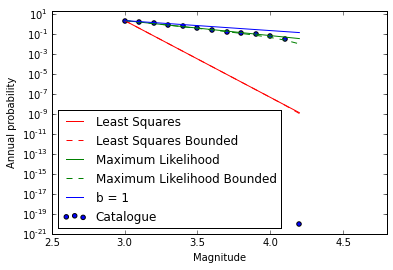

In [16]:
calc_recurrence(preset)

Checkpoint 0
Minimum magnitude: 3.0
Total number of earthquakes: 1731
Annual number of earthquakes greater than Mw 3.0 : 295.392491468
Maximum catalog magnitude: 5.6
Mmax =  5.7
Checkpoint 1: Data has been read
Checkpoint 2: Distribution has been formed
Least Squares: b value 2.72329515204 a value 11.6574819634
Maximum Likelihood: b value 1.53829291626
Checkpoint 3: Parameters a and b have been fit
Checkpoint 4: Data has been generated


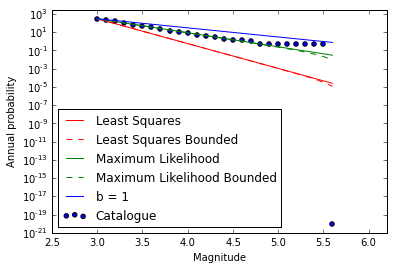

In [17]:
calc_recurrence(postset)